# Code providing the HVTINY-CNN model

Coyright notice: Code is support for paper R. Dogaru, I. Dogaru, R.C. Tecaru, "A Comparison of Several MCU-Oriented TinyML Models for Skin Lesions Classification", accepted to EHB2025 conference, Iasi - Romania, Nov. 2025 https://www.ehbconference.ro/
Copyright Radu and Ioana DOGARU; Contact radu.dogaru@upb.ro

# 0. Initialization

In [1]:
import keras
import tensorflow as tf
import numpy as np
print('Backend: ',keras.config.backend())
print('Keras version: ',keras.__version__)
print('Tensorflow version: ',tf.__version__)

def truncate_float(float_number, decimal_places):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier


from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
def get_flops(model):
  forward_pass = tf.function(model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
  graph_info = profile(forward_pass.get_concrete_function().graph, options=ProfileOptionBuilder.float_operation())
  flops = graph_info.total_float_ops
  return flops

2025-10-27 18:22:50.617979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761589370.810508      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761589370.869226      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Backend:  tensorflow
Keras version:  3.8.0
Tensorflow version:  2.18.0


# 1.1 - Dataset selection (here from Keras )

In [3]:
from keras.datasets import mnist, cifar10, cifar100, fashion_mnist

dataset='cifar10' # mnist or f-mnist or cifar10
batch_size=100


datagen=False
out_coding='cat' #
in_coding='clast'  #
test_exists=False
reduced=0  #  a positive value represents a reduced number of training samples (when memory allocation problems occur)

if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    test_labels=y_test; train_labels=y_train
elif  dataset=='cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # pentru INT 8
    test_labels=y_test[:,0]; train_labels=y_train[:,0]
elif  dataset=='cifar100':
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    # pentru INT 8
    test_labels=y_test[:,0]; train_labels=y_train[:,0]
#--- scaling
if (np.ndim(x_train)==3):   # La seturile de date MNIST or F-MNIST
        x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1])
        x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] )
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255

num_classes=int(np.max(y_train)+1)
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]
imsize=input_shape[0]

# categorical style
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
Ntr=np.shape(x_train)[0]; Nva=np.shape(x_test)[0];  # util sa avem numar train / ts
print('Training samples: ',Ntr); print('Validation samples: ',Nva);
print('Classes:   ',num_classes)
print('Input shape : ',input_shape)
print('Batch_size: ',batch_size)


Training samples:  50000
Validation samples:  10000
Classes:    10
Input shape :  (32, 32, 3)
Batch_size:  100


# 2.0. HVTINY Model - definition
Copyright Radu & Ioana Dogaru radu.dogaru@upb.ro


In [10]:
# HVTiny CNN
# Low complexity yet accurate model - well suited for MCU-oriented TinyML apps.
# Copyright Radu DOGARU, august-october 2025
#----------------------------------------------------------------------

def hvtiny(input_shape, num_classes, profil=[1, 4, 8, 4], k=4, c=3, flat=0, scale=True, drop=0.25, lr=0.001) :
        kernel_size = (3,3)
        pool_size = (4,4)
        pool_strides = (2,2)
        print('Profil: ',str(profil))
        drop1=drop
        pad='same'

        if scale:
            inputs = keras.Input(shape=input_shape) / 255 #
        else:
            inputs = keras.Input(shape=input_shape)
        n = int(k)

        # convolutional macro-block 0
        x = keras.layers.Conv2D(n, kernel_size, padding=pad)(inputs)  # Separable
        x = keras.layers.ReLU()(x)
        x = keras.layers.DepthwiseConv2D(kernel_size, padding=pad)(x)
        x = keras.layers.ReLU()(x)                                    # One may try an additional layer 
        x = keras.layers.DepthwiseConv2D(kernel_size, padding=pad)(x)
        #x = keras.layers.ReLU()(x)
        #x = keras.layers.DepthwiseConv2D(kernel_size, padding=pad)(x)
        #x=keras.layers.BatchNormalization()(x)                        # May help in some cases 
        x=keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_strides,padding=pad)(x)
        if drop1>0:
            x=keras.layers.Dropout(drop1)(x)
        number_of_cells_limited = False
        #adding macro-blocks 1,2 ... c
        for i in range(1, c + 1) :
            if x.shape[1] <= 1 or x.shape[2] <= 1 :
                number_of_cells_limited = True
                break;

            n=int(k*profil[i])
            x = keras.layers.SeparableConv2D(n, kernel_size, padding=pad)(x)
            x=keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_strides,padding=pad)(x)
            if drop1>0:
                x=keras.layers.Dropout(drop1)(x)

        # Output classifier
        if flat==0:
            x = keras.layers.GlobalAveragePooling2D()(x)
        else:
            x= keras.layers.Flatten()(x)
        #x = keras.layers.Dense(n, activation='relu')(x)
        x = keras.layers.BatchNormalization()(x)
        x=  keras.layers.Dropout(rate=0.4)(x)
        x = keras.layers.Dense(num_classes)(x)
        outputs = keras.layers.Softmax()(x)
        model = keras.Model(inputs=inputs, outputs=outputs)

        # scheduled rate
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            lr,
            decay_steps=50, # Numărul de pași după care rata de învățare scade
            decay_rate=0.9,    # Rata cu care scade
            staircase=False)    # Dacă este True, rata scade discret (în trepte), altfel continuu

        opt = tf.keras.optimizers.Adam(learning_rate=lr) # or lr_schedule

        model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        return model

# Celula 2.1: A specific model instance  

In [11]:
version='HVTINY' # VRES, V # VRES este cea mai compacta ; V = VCNN
#  sunt cu probleme: VR - loss=nan ?? ; V - .tflite difera f. mult ; # de rezolvat !
#
myflat=0; my_profil=[1, 3, 2]; myk=50; myc=2; mydrp=0.0;
lrate=0.002
myact='relu'  # or 'hard_silu'
myscale=False  #  false if already scaled ; True elsewhere
model=hvtiny(input_shape=input_shape, num_classes=num_classes, flat=myflat, profil=my_profil, k=myk, c=myc, scale=myscale, drop=mydrp, lr=lrate)
if myscale==False:
    mys='N'
elif myscale==True:
    mys='S'
model_name=version+'_'+mys+'_'+str(myflat)+'_d:'+str(mydrp)+'_'+str(my_profil)+'_k:'+str(myk)+'_c:'+str(myc)
print(model_name)
model.summary()

Profil:  [1, 3, 2]
HVTINY_N_0_d:0.0_[1, 3, 2]_k:50_c:2


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 50)     │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 32, 32, 50)     │           500 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 32, 32, 50)     │           500 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 16, 16, 150)    │         8,100 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 150)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 8, 8, 100)      │        16,450 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 100)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,360 (110.78 KB)

 Trainable params: 28,160 (110.00 KB)

 Non-trainable params: 200 (800.00 B)

# MAC complexity

In [12]:
flops = get_flops(model)
macs = flops / 2
print('Model size: ',model.count_params()//1000,'k ', 'MACs:', macs//1000, 'k')
print('Model size: ',model.count_params()//1000,'k ', 'MACs:', macs//1000, 'k')

Model size:  28 k  MACs: 5679.0 k
Model size:  28 k  MACs: 5679.0 k

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations.

# 3.1 checkpoint

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import time as ti
checkpoint = ModelCheckpoint('best_model.keras', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)

# Celula 3.2. Training process

In [ ]:
epoci= 150
import time as ti
t1=ti.time()

if datagen:
  history = model.fit(train_generator, epochs=epoci, validation_data=validation_generator, verbose=1,
                    callbacks = checkpoint)
else:
  history = model.fit(x_train, y_train, epochs=epoci, validation_data=(x_test, y_test), batch_size=batch_size, verbose=1,
                    callbacks = checkpoint)

t2=ti.time()
print('======================Training report  ==============================')
print('Training   ',epoci,' epochs, lasted  ',int(t2-t1)/60,' minutes')
my_eptr=truncate_float((t2-t1)/epoci,1)
model=load_model('best_model.keras')
best_val=truncate_float(100*np.max(history.history['val_accuracy']),2) # valid acc
best_tr=truncate_float(100*np.max(history.history['accuracy']),2)   # train acc
t1=ti.time()
if datagen:
    if test_exists:
      score = model.evaluate(test_generator, verbose=0)  # numai daca exista
      best_ts=truncate_float(100*score[1],2)
    else:
      score = model.evaluate(validation_generator, verbose=0)
      best_ts=truncate_float(100*score[1],2)
else:
    score = model.evaluate(x_test, y_test, verbose=0)
    best_ts=truncate_float(100*score[1],2)
t2=ti.time()

print('--------------------------------------')
kpars=truncate_float(model.count_params()/1000,2)
print ('Model size (k-pars): ',kpars)
print(' Best validation accuracy :', best_val,'%')
print('Dataset: ',dataset)
print('Model: ',model_name)
dsz=input_shape[1]
print('Img size: ',dsz)
print('Batch size: ', batch_size)


Epoch 1/150
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3527 - loss: 1.7618
Epoch 1: val_accuracy improved from -inf to 0.30400, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3538 - loss: 1.7591 - val_accuracy: 0.3040 - val_loss: 1.9632
Epoch 2/150
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6037 - loss: 1.1426
Epoch 2: val_accuracy improved from 0.30400 to 0.31620, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6039 - loss: 1.1422 - val_accuracy: 0.3162 - val_loss: 4.6256
Epoch 3/150
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6461 - loss: 1.0164
Epoch 3: val_accuracy did not improve from 0.31620
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6462 - loss: 1.0162 - val_accuracy: 0.1569 - val_loss: 4.4860
Epoch 4/150
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6748 - loss: 0.9370
Epoch 4: val_accuracy did not improve from 0.31620
500/500 ━━━━━━━━

# 3.3:  Confusion matrix  

In [99]:
model = load_model('best_model.keras')
from sklearn.metrics import classification_report, confusion_matrix

if datagen:
    t1=ti.time()
    if test_exists:
        accuracy = model.evaluate(test_generator)[1]
    else:
        accuracy = model.evaluate(validation_generator)[1]
    t2=ti.time()
    print(f"Acuratete set test = {accuracy*100} %")
    print ('Dimensiune model (parametri): ',model.count_params())
    print('Latenta per intreg set test: ', 1000*(t2-t1), 'mili seconds')
    if test_exists:
        mygen=test_generator
        my_latency=truncate_float(1000*(t2-t1)/N_test,2)
        print ('Timp predictie per esantion in setul de test: ',my_latency, 'ms' )
    else:
        mygen=validation_generator
        my_latency=truncate_float(1000*(t2-t1)/sbatch_size,2)
        print ('Timp predictie per esantion in setul de validare: ',my_latency, 'ms' )
    for i,j in mygen:
        print(i.shape, j.shape)
        p = model.predict(i)
        pq= p.argmax(-1)
        labels=(np.dot(j,np.array(range(num_classes)).T)).astype('int16')
        break;
    print(classification_report(labels,pq))
    print(confusion_matrix(labels,pq))
else:

   # Confusion matrix and more specific performance indicators
#----------------------------------------------------------------

    labels=(np.dot(y_test,np.array(range(num_classes)).T)).astype('int16')
    t1=ti.time()
    pred= model.predict(x_test)
    t2=ti.time()
    my_latency=truncate_float(1000*(t2-t1)/(x_test.shape[0]),2)
    print ('Latency: ',my_latency, 'ms' )

    predicted_class_indices=np.argmax(pred,axis=1)
    C=confusion_matrix(predicted_class_indices,labels)
    print (C)
    print('Classification Report')
    print(classification_report(labels,predicted_class_indices ))

if test_exists:
    tsts='|TestData|Ts_acc: '+str(best_ts)
else:
    tsts='ValData|Val_acc:'+str(best_ts)

my_MAC=truncate_float(macs//1000,2)
rep='_'+model_name+'_'+dataset+' Sz|'+str(dsz)+' Bt|'+str(batch_size)+' Lrate: '+str(lrate)+' Ep|'+str(epoci)
rep=rep+' Tep|'+str(my_eptr)+' Kpar|'+str(kpars)+'kMAC'+str(my_MAC)+' Vacc|'+str(best_val)+' TrAcc|'+str(best_tr)
rep=rep+tsts+' Lat|'+str(my_latency)
print('Repname: '+rep)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Latency:  0.29 ms
[[860  19  83  26  19  19  11  20  70  36]
 [  9 887   2  10   3   2   3   2  18  50]
 [ 29   6 682  50  51  32  28  30   4   5]
 [ 12   4  34 594  31  96  25  34   7   3]
 [  6   1  48  33 745  27  13  56   2   3]
 [  3   0  47 158  35 745   9  54   2   3]
 [  5   7  82  81  72  41 899  13   6   2]
 [  9   1  15  15  26  24   2 776   3   3]
 [ 44  19   4  18  12   9   5   3 867  23]
 [ 23  56   3  15   6   5   5  12  21 872]]
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      1000
           1       0.90      0.89      0.89      1000
           2       0.74      0.68      0.71      1000
           3       0.71      0.59      0.65      1000
           4       0.80      0.74      0.77      1000
           5       0.71      0.74      0.72      1000
           6       0.74      0.90      0.81      1000
           7       0.89      0.78      0.83      1000
 

# Training progress


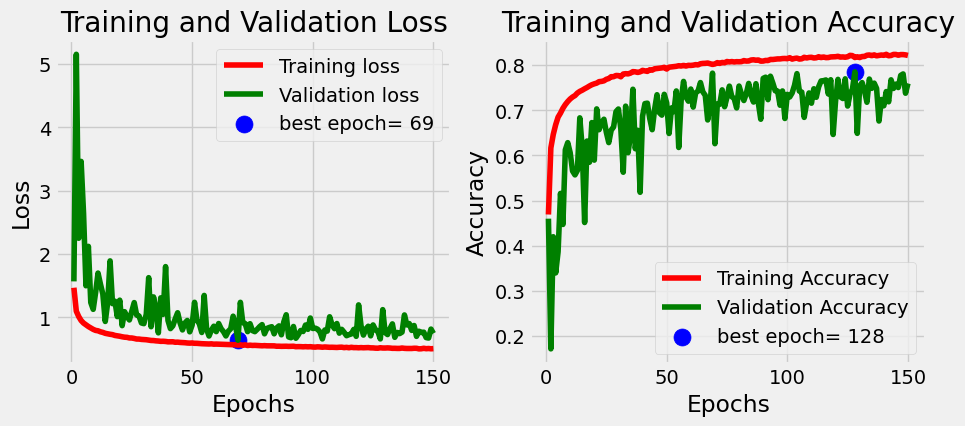

In [94]:

# adapted from  https://www.kaggle.com/code/youssefabdelghfar/brain-tumor-using-efficientnetb3
#print(rep)

from matplotlib import pyplot as plt
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (10, 4))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()